In [1]:
import findspark

In [2]:
findspark.init(r"C:\apache-spark\spark-2.4.3-bin-hadoop2.7")

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('Weblog').getOrCreate()

In [5]:
import re
import pandas as pd
import glob

raw_data_files = glob.glob(r'C:\Users\richa\Desktop\PythonPractice\BigData\PySpark\WeblogAnalysis\*.gz')
raw_data_files

['C:\\Users\\richa\\Desktop\\PythonPractice\\BigData\\PySpark\\WeblogAnalysis\\NASA_access_log_Aug95.gz',
 'C:\\Users\\richa\\Desktop\\PythonPractice\\BigData\\PySpark\\WeblogAnalysis\\NASA_access_log_Jul95.gz']

In [6]:
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [7]:
type(base_df)

pyspark.sql.dataframe.DataFrame

In [8]:
base_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
|burger.letters.com - - 

In [9]:
base_df.count()

3461613

In [10]:
sample_logs=[item['value'] for item in base_df.take(15)]

In [11]:
sample_logs

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '129.94.144.152 - - [01/Jul/

In [12]:
#extract the hostname from the logs

host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com',
 '199.120.110.21',
 'burger.letters.com',
 'burger.letters.com',
 '205.212.115.106',
 'd104.aa.net',
 '129.94.144.152',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'd104.aa.net',
 'd104.aa.net']

In [13]:
# Extracting timestamps

ts_pattern = r'\s+\[(\d+.*?)\]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:15 -0400',
 '01/Jul/1995:00:00:15 -0400']

In [14]:
#Extracting HTTP request method, URIs, and protocol

method_uri_protocol_pattern = r'\"(\S+)\s+(.*)\s+(.*?)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/history/apollo/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/liftoff.html', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/sts-73-patch-small.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/video/livevideo.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/countdown.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/KSC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0')]

In [15]:
#Extracting HTTP status codes

status_pattern = r'\"\s+(\d+)'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200', '200', '200', '200', '200', '200']


In [16]:
#Extracting HTTP response content size

content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['6245', '3985', '4085', '0', '4179', '0', '0', '3985', '3985', '7074', '40310', '786', '1204', '40310', '786']


In [17]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

In [18]:
base_df.filter(base_df['value'].isNull()).count()

0

In [19]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()|
                             logs_df['timestamp'].isNull() |
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

33905

In [20]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       33905|
+----+---------+------+--------+--------+------+------------+



In [21]:
#Handling nulls in HTTP status
logs_df = logs_df[logs_df['status'].isNotNull()]

In [22]:
#Fix the rows with null content_size
logs_df = logs_df.na.fill({'content_size': 0})

In [23]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [24]:
udf_parse_time = udf(parse_clf_time)

logs_df = (logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp'))
logs_df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


In [25]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461612
1,mean,18928.844398216785
2,stddev,73031.47260949228
3,min,0
4,max,6823936


In [28]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,18928.844398,73031.472609,3461612


In [27]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

In [43]:
status_freq_df = (logs_df.groupBy('status').count().sort('status').cache())

In [44]:
status_freq_df.count()

8

In [47]:
status_freq_pd_df = (status_freq_df.toPandas().sort_values(by=['count'],ascending=False))
status_freq_pd_df

,status,count
5,200,3100522
6,304,266773
7,302,73070
4,404,20901
3,403,225
1,500,65
0,501,41
2,400,15


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

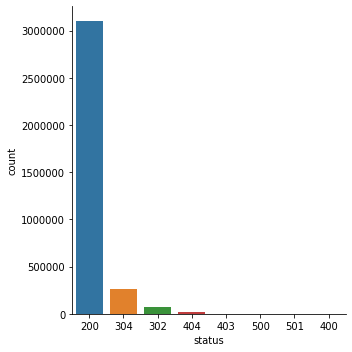

In [55]:
sns.catplot(x='status', y='count', data=status_freq_pd_df,
            kind='bar', order=status_freq_pd_df['status'])

In [57]:
log_freq_df = status_freq_df.withColumn('log(count)',F.log(status_freq_df['count']))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|   501|     41| 3.713572066704308|
|   500|     65| 4.174387269895637|
|   400|     15|  2.70805020110221|
|   403|    225|  5.41610040220442|
|   404|  20901|  9.94755228369823|
|   200|3100522|14.947081042376633|
|   304| 266773|12.494153388502301|
|   302|  73070|11.199173164785263|
+------+-------+------------------+



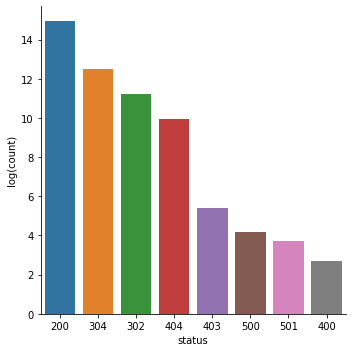

In [58]:
log_freq_pd_df = (log_freq_df.toPandas().sort_values(by=['log(count)'],ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, kind='bar', order=status_freq_pd_df['status'])

In [59]:
host_sum_df =(logs_df.groupBy('host').count().sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|                    |7660 |
|siltb10.orl.mmc.com |7573 |
+--------------------+-----+



In [61]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[8]['host']

''

In [70]:
#Display the top 20 most frequent endpoints
paths_df = (logs_df.groupBy('endpoint').count().sort('count',ascending=False)).limit(20).toPandas()

paths_df

,endpoint,count
0,/images/NASA-logosmall.gif,208353
1,/images/KSC-logosmall.gif,164807
2,/images/MOSAIC-logosmall.gif,127648
3,/images/USA-logosmall.gif,126812
4,/images/WORLD-logosmall.gif,125668
5,/images/ksclogo-medium.gif,121278
6,/ksc.html,83679
7,/images/launch-logo.gif,75957
8,/history/apollo/images/apollo-logo1.gif,68856
9,/shuttle/countdown/,64689


In [71]:
#Display the top 10 error endpoints

not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )
                         
error_endpoints_freq_df.show(truncate=False)   

+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



In [72]:
#Total number of unique hosts

unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

137933

In [73]:
# Number of unique daily hosts

host_day_df = logs_df.select(logs_df.host,F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+--------------------+---+
|host                |day|
+--------------------+---+
|199.72.81.55        |1  |
|unicomp6.unicomp.net|1  |
|199.120.110.21      |1  |
|burger.letters.com  |1  |
|199.120.110.21      |1  |
+--------------------+---+
only showing top 5 rows



In [77]:
host_day_distinct_df  = logs_df.select(logs_df.host,
                             F.dayofmonth('time').alias('day')).distinct()
host_day_df.show(5, truncate=False)

+--------------------+---+
|host                |day|
+--------------------+---+
|199.72.81.55        |1  |
|unicomp6.unicomp.net|1  |
|199.120.110.21      |1  |
|burger.letters.com  |1  |
|199.120.110.21      |1  |
+--------------------+---+
only showing top 5 rows



In [78]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,1,7609
1,2,4858
2,3,10238
3,4,9411
4,5,9640
...,...,...
26,27,6846
27,28,6090
28,29,4825
29,30,5265


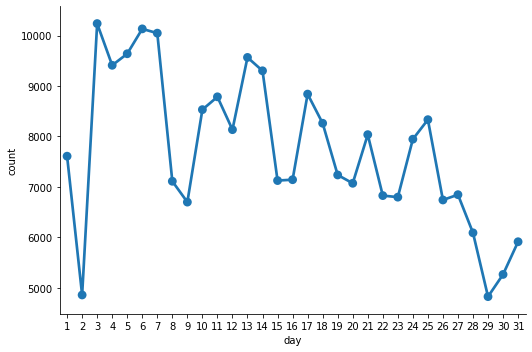

In [82]:
c = sns.catplot(x='day', y='count',data=daily_hosts_df,kind='point', height=5,aspect=1.5)

In [83]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"),
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"),
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,98710,7609,12.972795
1,2,60265,4858,12.405311
2,3,130972,10238,12.792733
3,4,130009,9411,13.814579
4,5,126468,9640,13.119087
...,...,...,...,...
26,27,94503,6846,13.804119
27,28,82617,6090,13.566010
28,29,67988,4825,14.090777
29,30,80641,5265,15.316429


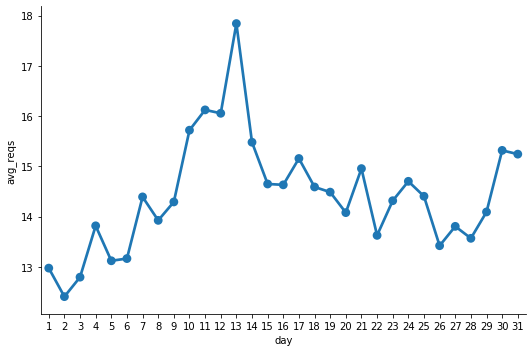

In [84]:

c = sns.catplot(x='day', y='avg_reqs',
                data=avg_daily_reqests_per_host_df,
                kind='point', height=5, aspect=1.5)

In [85]:

not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 20901


In [86]:
#Listing the top twenty 404 response code endpoints
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |2004 |
|/pub/winvn/release.txt                                           |1732 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |682  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |426  |
|/history/apollo/a-001/a-001-patch-small.gif                      |384  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |383  |
|/://spacelink.msfc.nasa.gov                                      |381  |
|/images/crawlerway-logo.gif                                      |374  |
|/elv/DELTA/uncons.htm                                            |372  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|359  |
|/images/nasa-logo.gif                

In [89]:
#Listing the top twenty 404 response code hosts
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|piweba3y.prodigy.com       |157  |
|jbiagioni.npt.nuwc.navy.mil|132  |
|piweba1y.prodigy.com       |114  |
|                           |112  |
|www-d4.proxy.aol.com       |91   |
|piweba4y.prodigy.com       |86   |
|scooter.pa-x.dec.com       |69   |
|www-d1.proxy.aol.com       |64   |
|phaelon.ksc.nasa.gov       |64   |
|dialip-217.den.mmc.com     |62   |
|www-b4.proxy.aol.com       |62   |
|www-b3.proxy.aol.com       |61   |
|www-a2.proxy.aol.com       |60   |
|www-d2.proxy.aol.com       |59   |
|piweba2y.prodigy.com       |59   |
|alyssa.prodigy.com         |56   |
|monarch.eng.buffalo.edu    |56   |
|www-b2.proxy.aol.com       |53   |
|www-c4.proxy.aol.com       |53   |
+---------------------------+-----+



In [90]:
#Visualizing 404 errors per day
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,559
1,2,291
2,3,778
3,4,705
4,5,733
...,...,...
26,27,706
27,28,504
28,29,420
29,30,571


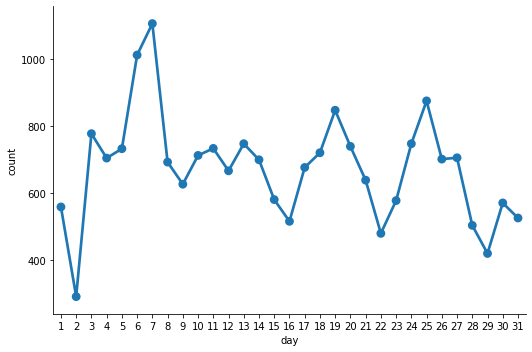

In [91]:
c = sns.catplot(x='day', y='count',
                data=errors_by_date_sorted_pd_df,
                kind='point', height=5, aspect=1.5)

In [92]:
#Top three days for 404 errors

(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
|  7| 1107|
|  6| 1013|
| 25|  876|
+---+-----+
only showing top 3 rows



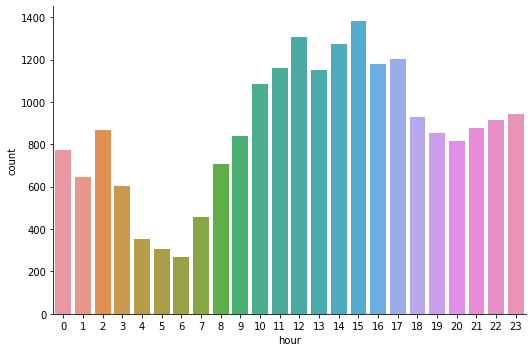

In [94]:
#Visualizing hourly 404 errors
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

c = sns.catplot(x='hour', y='count',
                data=hourly_avg_errors_sorted_pd_df,
                kind='bar', height=5, aspect=1.5)